# **Gesture Recognition Assignment (IIIT BANGLORE_2022)**
## ***BY ASHWINI ABHANG***

## Problem Statement: - 
Imagine you are working as a data scientist at a home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote. The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:

1. Thumbs up:  Increase the volume <br>
2. Thumbs down: Decrease the volume <br>
3. Left swipe: 'Jump' backwards 10 seconds <br>
4. Right swipe: 'Jump' forward 10 seconds  
5. Stop: Pause the movie
 

Each video is a sequence of 30 frames (or images). In the next couple of lectures, our subject matter expert Snehansu will walk you through the structure of the dataset.



## Understanding the Dataset
The training data consists of a few hundred videos categorised into one of the five classes. Each video (typically 2-3 seconds long) is divided into a sequence of 30 frames(images). These videos have been recorded by various people performing one of the five gestures in front of a webcam - similar to what the smart TV will use. 

 The data is in a zip file. The zip file contains a 'train' and a 'val' folder with two CSV files for the two folders. These folders are in turn divided into subfolders where each subfolder represents a video of a particular gesture. Each subfolder, i.e. a video, contains 30 frames (or images). Note that all images in a particular video subfolder have the same dimensions but different videos may have different dimensions. Specifically, videos have two types of dimensions - either 360x360 or 120x160 (depending on the webcam used to record the videos). Hence, you will need to do some pre-processing to standardise the videos. 

 

Each row of the CSV file represents one video and contains three main pieces of information - the name of the subfolder containing the 30 images of the video, the name of the gesture and the numeric label (between 0-4) of the video.

 

Your task is to train a model on the 'train' folder which performs well on the 'val' folder as well (as usually done in ML projects). We have withheld the test folder for evaluation purposes - your final model's performance will be tested on the 'test' set.

## Importing all the necessary dependencies and setting the random seed so that the results don't vary drastically.

In [ ]:
!!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

['',
 'Reading package lists... 0%',
 '',
 'Reading package lists... 0%',
 '',
 'Reading package lists... 0%',
 '',
 'Reading package lists... 4%',
 '',
 'Reading package lists... 4%',
 '',
 'Reading package lists... 4%',
 '',
 'Reading package lists... 4%',
 '',
 'Reading package lists... 22%',
 '',
 'Reading package lists... 45%',
 '',
 'Reading package lists... 45%',
 '',
 'Reading package lists... 45%',
 '',
 'Reading package lists... 45%',
 '',
 'Reading package lists... 57%',
 '',
 'Reading package lists... 57%',
 '',
 'Reading package lists... 62%',
 '',
 'Reading package lists... 62%',
 '',
 'Reading package lists... 69%',
 '',
 'Reading package lists... 70%',
 '',
 'Reading package lists... 70%',
 '',
 'Reading package lists... 70%',
 '',
 'Reading package lists... 70%',
 '',
 'Reading package lists... 70%',
 '',
 'Reading package lists... 70%',
 '',
 'Reading package lists... 70%',
 '',
 'Reading package lists... 70%',
 '',
 'Reading package lists... 81%',
 '',
 'Reading pack

In [1]:
import numpy as np
import os
import imageio
from skimage.transform import resize, rescale
import datetime
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import random as rn
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, GRU, LSTM, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.regularizers import l2
from keras import optimizers
from keras.applications import mobilenet
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
print(tf.__version__)
np.random.seed(30)
rn.seed(30)
tf.random.set_seed(30)



2.8.2


### In the below code I read the folders names for training and validation

In [2]:
train_doc = np.random.permutation(open('/content/drive/MyDrive/Gesture Recognition/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/content/drive/MyDrive/Gesture Recognition/Project_data/val.csv').readlines())
num_classes = 5  #number of softmax classes

### In this section I define the training and validation path. I also check for the number of training and validation sequences.

In [3]:
curr_dt_time = datetime.datetime.now()
train_path = '/content/drive/MyDrive/Gesture Recognition/Project_data/train'
val_path = '/content/drive/MyDrive/Gesture Recognition/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

# training sequences = 663
# validation sequences = 100


## In the below section I define the common functions that will be required throughout the code.


#### The below function is defined to plot the accuracy and loss graphs for the models being trained

In [4]:
def plot_loss_accuracy(history):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

### In this section I define the steps per epoch and the validation steps that are required during training.

In [5]:
def calculate_steps(num_train_sequences, num_val_sequences, batch_size):
    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1

    return steps_per_epoch,validation_steps

#### Here I define the callback function which saves the best model by creating a folder for its weight by using Modelcheckpoint and I also define ReduceLROnPlateau which reduces the learning rate if the model starts to plateau at some point during the training phase.

In [6]:
def model_callbacks(folder_name):
    model_name = str(folder_name) + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
   
    if not os.path.exists(model_name):
        os.mkdir(model_name)

    filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')

    LR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, min_lr=0.0001, cooldown=1, verbose=1) # write the REducelronplateau code here

    return [checkpoint, LR]    

## Building a Generator 

#### Using pre-built generator to understand generators

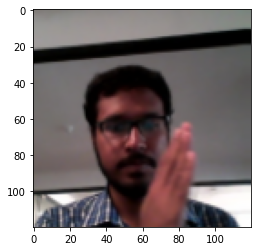

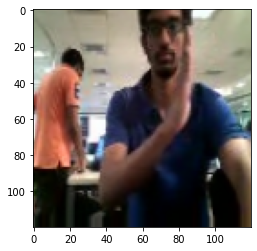

In [7]:
datagen = ImageDataGenerator(
    zoom_range=0.1,
    zca_whitening=True,
    width_shift_range=0.1,
    height_shift_range=0.1)

## Test code start
#360 by 360
image1 = imageio.imread("/content/drive/MyDrive/Gesture Recognition/Project_data/val/WIN_20180907_15_30_06_Pro_Right Swipe_new/WIN_20180907_15_30_06_Pro_00029.png")
#160 by 120
image2 = imageio.imread("/content/drive/MyDrive/Gesture Recognition/Project_data/val/WIN_20180926_17_56_52_Pro_Right_Swipe_new/WIN_20180926_17_56_52_Pro_00029.png")
#crop the images and resize them. Note that the images are of 2 different shape 
#and the conv3D will throw error if the inputs in a batch have different shapes                    
#print(image1.shape, image2.shape)
image1 = resize(image1, (120, 120), anti_aliasing=True)
image1 = datagen.random_transform(image1)                   
plt.imshow(image1)
plt.show()
image2 = resize(image2, (120, 120), anti_aliasing=True)
image2 = datagen.random_transform(image2)                 
plt.imshow(image2)
plt.show()
## Test code end

#### Defining a self built generator function 
It is built to cater my needs. This is one of the most important part of the code. The overall structure of the generator has been given. In the generator,I am  going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with img_idx, y,z and normalization such that you get high accuracy.

In [8]:
def generate(source_path, folder_list, batch_size, num_images=20, height=120, width=120, augment=False):
    #print( 'Source path = ', source_path, '; batch size =', batch_size)
    total_frames = 30

    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t)//batch_size # calculate the number of batches
        #img_idx = sorted(rn.sample(range(0, total_frames), num_images)) #create a list of image numbers you want to use for a particular video
        img_idx = np.round(np.linspace(0,total_frames-1,num_images)).astype(int) #create a list of image numbers you want to use for a particular video

        for batch in range(num_batches): # we iterate over the number of batches
            batch_data   = np.zeros((batch_size, num_images, height, width, 3)) # 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size, 5)) # batch_labels is the one hot representation of the output           

            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
                    image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes                    
                    h, w, c = image.shape
                    image = resize(image, (height, width), anti_aliasing=True)

                    # Randomly transform few images of few folders; note that folders are randomly shuffled in each epoch too
                    if augment:
                        if np.random.randn() > 0:
                            image = datagen.random_transform(image)                   

                    batch_data[folder,idx,:,:,0] = (image[...,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image[...,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image[...,2])/255 #normalise and feed in the image                  
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
        
        # write the code for the remaining data points which are left after full batches
        if (len(t)%batch_size):
            remaining_batch_size = len(t)%batch_size
            batch_data   = np.zeros((remaining_batch_size, num_images, height, width,3)) # 3 is the number of channels RGB
            batch_labels = np.zeros((remaining_batch_size,5)) # batch_labels is the one hot representation of the output           

            for folder in range(remaining_batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imageio.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    h, w, c = image.shape
                    image = resize(image, (height, width), anti_aliasing=True)                          
                    
                    # Randomly transform few images of few folders; note that folders are randomly shuffled in each epoch too
                    if augment:
                        if np.random.randn() > 0:
                            image = datagen.random_transform(image)                   

                    batch_data[folder,idx,:,:,0] = (image[...,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image[...,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image[...,2])/255 #normalise and feed in the image
                    #batch_data[folder,idx,:,:,0] = (image[...,0] - image[...,0].min())/(image[...,0].max() - image[...,0].min())#normalise and feed in the image
                    #batch_data[folder,idx,:,:,1] = (image[...,1] - image[...,1].min())/(image[...,1].max() - image[...,1].min())#normalise and feed in the image
                    #batch_data[folder,idx,:,:,2] = (image[...,2] - image[...,2].min())/(image[...,2].max() - image[...,2].min())#normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


## Model Building
#### Here in this project I have used two different methods to build the model:-


1.   Model Building Using Conv3D Layers
2.   Model Building Using Conv2D + RNN/ Model Building Using Transfer Learning + RNN



### 1. Model Building Using Conv3D Layers

#### Here I make the model using different functionalities that Keras provides. I have used Conv3D and MaxPooling3D and not Conv2D and Maxpooling2D for a 3D convolution model.  Here the last layer is the softmax. I have designed and experimented with the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [9]:
# Common utility to create conv 3D models
def conv3D(conv_filters=(16, 32, 64, 128), dense_nodes=(256,128), dropout=0.25, num_images=20, height=120, width=120):

    model = Sequential()

    model.add(Conv3D(conv_filters[0], (3, 3, 3), padding='same', input_shape=(num_images, height, width, 3)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(conv_filters[1], (3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Conv3D(conv_filters[2], (3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Conv3D(conv_filters[3], (3, 3, 3), padding='same'))    
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Flatten())
    model.add(Dense(dense_nodes[0]))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(dense_nodes[1]))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    opt = tf.keras.optimizers.Adam() #write your optimizer
    model.compile(opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])    
    
    return model

### Model Experimentation for Conv3D

#### Conv 3D Model with 30 frames per video
16, 32, 64, 128 filters conv 3D layers + 128 dense layer + 64 dense layer + image size 120 by 120


In [10]:
num_epochs = 25 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 30
print ('# num_frames per video =', num_frames)
height = 120
width = 120

model = conv3D(num_images=num_frames)

print (model.summary())

# epochs = 25
# batch size = 10
# num_frames per video = 30
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 30, 120, 120, 16)  1312      
                                                                 
 activation (Activation)     (None, 30, 120, 120, 16)  0         
                                                                 
 batch_normalization (BatchN  (None, 30, 120, 120, 16)  64       
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 15, 60, 60, 16)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 15, 60, 60, 32)    13856     
                                                              

 The steps_per_epoch and validation_steps are used by fit_generator to decide the number of next() calls it need to make.I will now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [11]:
callbacks_list = model_callbacks("model_conv3D_1")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

Using model.fit to fit the train generator and to train the model on the data.

In [12]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                             callbacks=callbacks_list, validation_data=val_generator, 
                             validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/25
67/67 [==============================] - ETA: 0s - loss: 1.5702 - categorical_accuracy: 0.4284 
Epoch 1: val_loss improved from inf to 3.50055, saving model to model_conv3D_1_2022-09-1402_44_34.816729/model-00001-1.57015-0.42836-3.50055-0.25000.h5
67/67 [==============================] - 2489s 38s/step - loss: 1.5702 - categorical_accuracy: 0.4284 - val_loss: 3.5005 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 2/25
67/67 [==============================] - ETA: 0s - loss: 1.2026 - categorical_accuracy: 0.5354
Epoch 2: val_loss did not improve from 3.50055
67/67 [==============================] - 323s 5s/step - loss: 1.2026 - categorical_accuracy: 0.5354 - val_loss: 5.9016 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 3/25
67/67 [==============================] - ETA: 0s - loss: 1.0752 - categorical_accuracy: 0.5732
Epoch 3: val_loss did not improve from 3.50055
67/67 [==============================] - 322s 5s/step - loss: 1.0752 - categorical_accuracy: 0.5732

Visualizing the Results

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


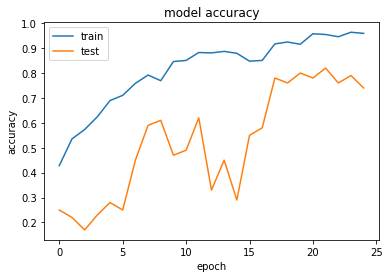

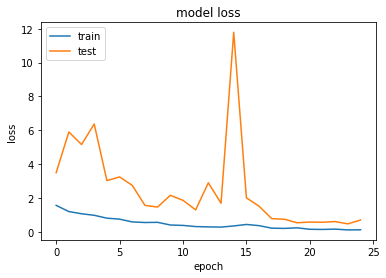

In [13]:
plot_loss_accuracy(history)

#### Conv 3D Model with 20 frames per video
16, 32, 64, 128 filters conv 3D layers + 256 dense layer + 128 dense layer + image size 120 by 120

In [13]:
num_epochs = 25 # choose the number of epochs
#print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num_frames per video =', num_frames)
height = 120
width = 120

model = conv3D(num_images=num_frames)

print (model.summary())

# batch size = 10
# num_frames per video = 20
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 20, 120, 120, 16)  1312      
                                                                 
 activation_7 (Activation)   (None, 20, 120, 120, 16)  0         
                                                                 
 batch_normalization_6 (Batc  (None, 20, 120, 120, 16)  64       
 hNormalization)                                                 
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 10, 60, 60, 16)   0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 10, 60, 60, 32)    13856     
                                                                 
 activat

The steps_per_epoch and validation_steps are used by fit_generator to decide the number of next() calls it need to make. Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [14]:
callbacks_list = model_callbacks("model_conv3D_2")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

Using model.fit to fit the train generator and to train the model on the data.

In [15]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/25
67/67 [==============================] - ETA: 0s - loss: 1.6130 - categorical_accuracy: 0.4314
Epoch 1: val_loss improved from inf to 3.37754, saving model to model_conv3D_2_2022-09-1319_24_29.815402/model-00001-1.61302-0.43137-3.37754-0.19000.h5
67/67 [==============================] - 177s 3s/step - loss: 1.6130 - categorical_accuracy: 0.4314 - val_loss: 3.3775 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 2/25
67/67 [==============================] - ETA: 0s - loss: 1.2793 - categorical_accuracy: 0.5234
Epoch 2: val_loss improved from 3.37754 to 2.61401, saving model to model_conv3D_2_2022-09-1319_24_29.815402/model-00002-1.27935-0.52338-2.61401-0.25000.h5
67/67 [==============================] - 178s 3s/step - loss: 1.2793 - categorical_accuracy: 0.5234 - val_loss: 2.6140 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 3/25
67/67 [==============================] - ETA: 0s - loss: 1.0480 - categorical_accuracy: 0.5928
Epoch 3: val_loss did not improve from 2

Visualizing the Results

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


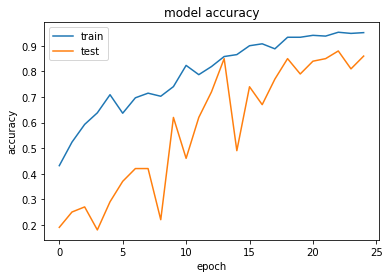

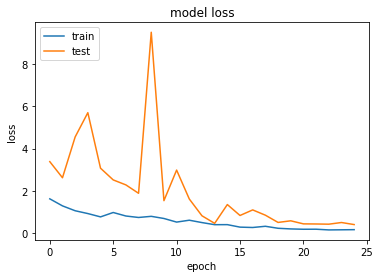

In [16]:
plot_loss_accuracy(history)

#### Conv 3D Model with 30 frames per video 
16, 32, 64, 128 filters conv 3D layers + 256 dense layer + 128 dense layer + image size 160 by 160

In [ ]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 30
print ('# num_frames per video =', num_frames)
height = 160
width = 160

model = conv3D(num_images=num_frames, height=160, width=160)

print (model.summary())

# epochs = 20
# batch size = 10
# num_frames per video = 30
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 30, 160, 160, 16)  1312      
                                                                 
 activation_14 (Activation)  (None, 30, 160, 160, 16)  0         
                                                                 
 batch_normalization_12 (Bat  (None, 30, 160, 160, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 15, 80, 80, 16)   0         
 3D)                                                             
                                                                 
 conv3d_9 (Conv3D)           (None, 15, 80, 80, 32)    13856     
                                                            

The steps_per_epoch and validation_steps are used by fit_generator to decide the number of next() calls it need to make. Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [ ]:
callbacks_list = model_callbacks("model_conv3D_3")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames, height=160, width=160)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames, height=160, width=160)

Using model.fit to fit the train generator and to train the model on the data.

In [ ]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20
67/67 [==============================] - ETA: 0s - batch: 33.0000 - size: 9.8955 - loss: 1.5748 - categorical_accuracy: 0.4268 
Epoch 1: val_loss improved from inf to 5.65569, saving model to model_conv3D_3_2022-09-1015_12_31.381395/model-00001-1.56729-0.42685-5.65569-0.21000.h5
67/67 [==============================] - 320s 5s/step - batch: 33.0000 - size: 9.8955 - loss: 1.5747 - categorical_accuracy: 0.4268 - val_loss: 5.6557 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/20
67/67 [==============================] - ETA: 0s - batch: 33.0000 - size: 9.8955 - loss: 1.1424 - categorical_accuracy: 0.5490 
Epoch 2: val_loss did not improve from 5.65569
67/67 [==============================] - 276s 4s/step - batch: 33.0000 - size: 9.8955 - loss: 1.1425 - categorical_accuracy: 0.5490 - val_loss: 7.0343 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 3/20
67/67 [==============================] - ETA: 0s - batch: 33.0000 - size: 9.8955 - loss: 0.9559 - categorical_accu

Visualizing the Results

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


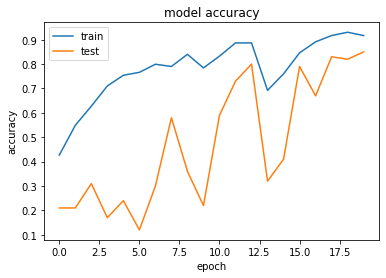

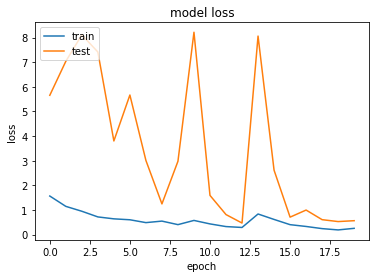

In [ ]:
plot_loss_accuracy(history)


#### Conv 3D Model with 20 frames per video 
16, 32, 64, 128 filters conv 3D layers + 256 dense layer + 128 dense layer + image size 160 by 160

In [ ]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num_frames per video =', num_frames)
height = 160
width = 160

model = conv3D(num_images=num_frames, height=160, width=160)

print (model.summary())

# epochs = 20
# batch size = 10
# num_frames per video = 20
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_16 (Conv3D)          (None, 20, 160, 160, 16)  1312      
                                                                 
 activation_28 (Activation)  (None, 20, 160, 160, 16)  0         
                                                                 
 batch_normalization_24 (Bat  (None, 20, 160, 160, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_16 (MaxPoolin  (None, 10, 80, 80, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_17 (Conv3D)          (None, 10, 80, 80, 32)    13856     
                                                            

The steps_per_epoch and validation_steps are used by fit_generator to decide the number of next() calls it need to make. Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [ ]:
callbacks_list = model_callbacks("model_conv3D_4")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames, height=160, width=160)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames, height=160, width=160)

Using model.fit to fit the train generator and to train the model on the data.

In [ ]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20
67/67 [==============================] - ETA: 0s - batch: 33.0000 - size: 9.8955 - loss: 1.6567 - categorical_accuracy: 0.4193 
Epoch 1: val_loss improved from inf to 2.73463, saving model to model_conv3D_4_2022-09-1104_36_33.553445/model-00001-1.67093-0.41931-2.73463-0.24000.h5
67/67 [==============================] - 226s 3s/step - batch: 33.0000 - size: 9.8955 - loss: 1.6569 - categorical_accuracy: 0.4193 - val_loss: 2.7346 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 2/20
67/67 [==============================] - ETA: 0s - batch: 33.0000 - size: 9.8955 - loss: 1.1753 - categorical_accuracy: 0.5686 
Epoch 2: val_loss did not improve from 2.73463
67/67 [==============================] - 216s 3s/step - batch: 33.0000 - size: 9.8955 - loss: 1.1751 - categorical_accuracy: 0.5686 - val_loss: 3.8494 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 3/20
67/67 [==============================] - ETA: 0s - batch: 33.0000 - size: 9.8955 - loss: 1.0634 - categorical_accu

Visualizing the Results

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


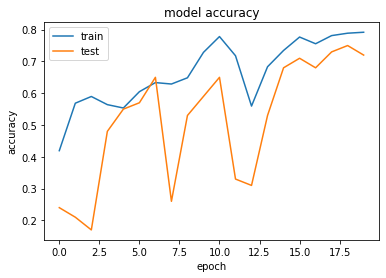

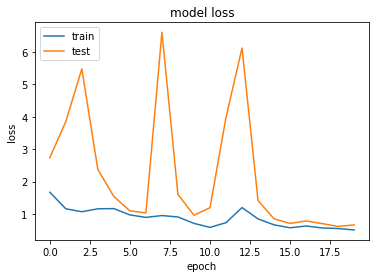

In [ ]:
plot_loss_accuracy(history)

#### Conv 3D Model with 30 frames per video 
16, 32, 64, 128 filters conv 3D layers + 256 dense layer + 128 dense layer + Random data transformations on training data set

In [ ]:
num_epochs = 15 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 30
print ('# num_frames per video =', num_frames)
height = 120
width = 120

model = conv3D(num_images=num_frames)

print (model.summary())

# epochs = 15
# batch size = 10
# num_frames per video = 30
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_20 (Conv3D)          (None, 30, 120, 120, 16)  1312      
                                                                 
 activation_35 (Activation)  (None, 30, 120, 120, 16)  0         
                                                                 
 batch_normalization_30 (Bat  (None, 30, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_20 (MaxPoolin  (None, 15, 60, 60, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_21 (Conv3D)          (None, 15, 60, 60, 32)    13856     
                                                            

The steps_per_epoch and validation_steps are used by fit_generator to decide the number of next() calls it need to make. Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [ ]:
callbacks_list = model_callbacks("model_conv3D_5")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, augment=True, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

Using model.fit to fit the train generator and to train the model on the data.

In [ ]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/15
67/67 [==============================] - ETA: 0s - batch: 33.0000 - size: 9.8955 - loss: 1.5755 - categorical_accuracy: 0.4465 
Epoch 1: val_loss improved from inf to 5.03543, saving model to model_conv3D_5_2022-09-1104_36_33.553445/model-00001-1.57981-0.44646-5.03543-0.21000.h5
67/67 [==============================] - 337s 5s/step - batch: 33.0000 - size: 9.8955 - loss: 1.5755 - categorical_accuracy: 0.4465 - val_loss: 5.0354 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/15
67/67 [==============================] - ETA: 0s - batch: 33.0000 - size: 9.8955 - loss: 1.2148 - categorical_accuracy: 0.5445 
Epoch 2: val_loss did not improve from 5.03543
67/67 [==============================] - 288s 4s/step - batch: 33.0000 - size: 9.8955 - loss: 1.2145 - categorical_accuracy: 0.5445 - val_loss: 5.6260 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 3/15
67/67 [==============================] - ETA: 0s - batch: 33.0000 - size: 9.8955 - loss: 1.0488 - categorical_accu

Visualizing the Results

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


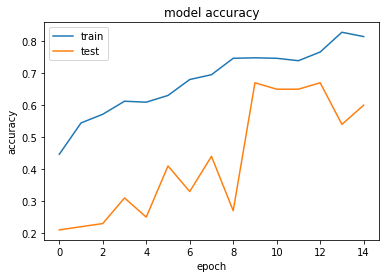

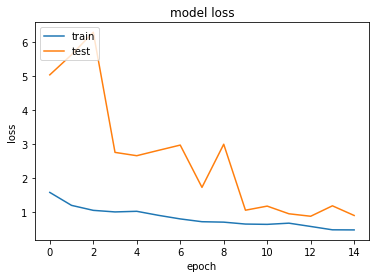

In [ ]:
plot_loss_accuracy(history)

#### Conv 3D Model with 30 frames per video 
8, 16, 32, 64 filters conv 3D layers + 256 dense layer + 128 dense layer + image size 120 by 120

In [ ]:
num_epochs = 25 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 30
print ('# num_frames per video =', num_frames)
height = 120
width = 120

conv_filters = (8, 16, 32, 64) 
model = conv3D(conv_filters, num_images=num_frames)
print (model.summary())

# epochs = 25
# batch size = 10
# num_frames per video = 30
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_24 (Conv3D)          (None, 30, 120, 120, 8)   656       
                                                                 
 activation_42 (Activation)  (None, 30, 120, 120, 8)   0         
                                                                 
 batch_normalization_36 (Bat  (None, 30, 120, 120, 8)  32        
 chNormalization)                                                
                                                                 
 max_pooling3d_24 (MaxPoolin  (None, 15, 60, 60, 8)    0         
 g3D)                                                            
                                                                 
 conv3d_25 (Conv3D)          (None, 15, 60, 60, 16)    3472      
                                                            

The steps_per_epoch and validation_steps are used by fit_generator to decide the number of next() calls it need to make. Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [ ]:
callbacks_list = model_callbacks("model_conv3D_6")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

Using model.fit to fit the train generator and to train the model on the data.

In [ ]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/25
67/67 [==============================] - ETA: 0s - batch: 33.0000 - size: 9.8955 - loss: 1.6227 - categorical_accuracy: 0.4027 
Epoch 1: val_loss improved from inf to 2.70434, saving model to model_conv3D_6_2022-09-1104_36_33.553445/model-00001-1.62372-0.40271-2.70434-0.32000.h5
67/67 [==============================] - 300s 4s/step - batch: 33.0000 - size: 9.8955 - loss: 1.6227 - categorical_accuracy: 0.4027 - val_loss: 2.7043 - val_categorical_accuracy: 0.3200 - lr: 0.0010
Epoch 2/25
67/67 [==============================] - ETA: 0s - batch: 33.0000 - size: 9.8955 - loss: 1.1843 - categorical_accuracy: 0.5249 
Epoch 2: val_loss did not improve from 2.70434
67/67 [==============================] - 248s 4s/step - batch: 33.0000 - size: 9.8955 - loss: 1.1844 - categorical_accuracy: 0.5249 - val_loss: 4.8648 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 3/25
67/67 [==============================] - ETA: 0s - batch: 33.0000 - size: 9.8955 - loss: 0.9961 - categorical_accu

Visualizing the Results.

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


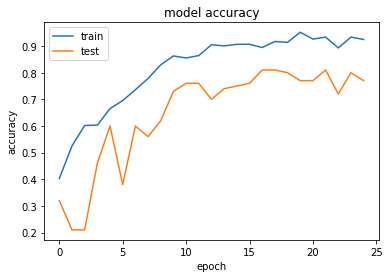

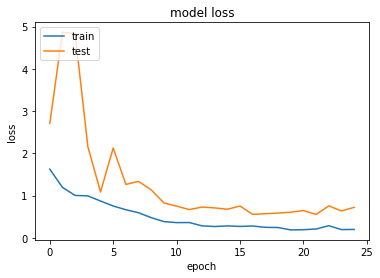

In [ ]:
plot_loss_accuracy(history)

#### Conv 3D Model with 20 frames per video 
16, 32, 64, 128 filters conv 3D layers + 128 dense layer + 64 dense layer + image size 120 by 120

In [ ]:
num_epochs = 25 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 30
print ('# num_frames per video =', num_frames)
height = 120
width = 120

conv_filters = (16, 32, 64, 128)
dense_filters = (128, 64) 
model = conv3D(conv_filters=conv_filters, dense_nodes=dense_filters, dropout=0.2, num_images=num_frames)
print (model.summary())

# epochs = 25
# batch size = 10
# num_frames per video = 30
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_28 (Conv3D)          (None, 30, 120, 120, 16)  1312      
                                                                 
 activation_49 (Activation)  (None, 30, 120, 120, 16)  0         
                                                                 
 batch_normalization_42 (Bat  (None, 30, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_28 (MaxPoolin  (None, 15, 60, 60, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_29 (Conv3D)          (None, 15, 60, 60, 32)    13856     
                                                            

The steps_per_epoch and validation_steps are used by fit_generator to decide the number of next() calls it need to make. Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [ ]:
callbacks_list = model_callbacks("model_conv3D_7")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, augment=False, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

Using model.fit to fit the train generator and to train the model on the data.

In [ ]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/25
67/67 [==============================] - ETA: 0s - batch: 33.0000 - size: 9.8955 - loss: 1.6235 - categorical_accuracy: 0.4223 
Epoch 1: val_loss improved from inf to 2.72668, saving model to model_conv3D_7_2022-09-1104_36_33.553445/model-00001-1.63237-0.42232-2.72668-0.18000.h5
67/67 [==============================] - 346s 5s/step - batch: 33.0000 - size: 9.8955 - loss: 1.6237 - categorical_accuracy: 0.4223 - val_loss: 2.7267 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 2/25
67/67 [==============================] - ETA: 0s - batch: 33.0000 - size: 9.8955 - loss: 1.1055 - categorical_accuracy: 0.5716 
Epoch 2: val_loss did not improve from 2.72668
67/67 [==============================] - 254s 4s/step - batch: 33.0000 - size: 9.8955 - loss: 1.1056 - categorical_accuracy: 0.5716 - val_loss: 3.3266 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 3/25
67/67 [==============================] - ETA: 0s - batch: 33.0000 - size: 9.8955 - loss: 0.9944 - categorical_accu

Visualizing the Results.

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


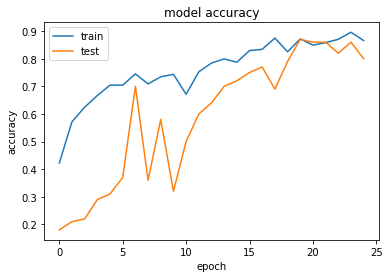

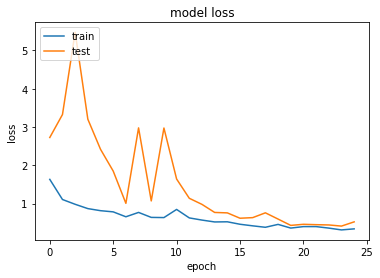

In [ ]:
plot_loss_accuracy(history)

#### Conv 3D Model with 20 frames per video 
32, 64, 128, 256 filters conv 3D layers + 128 dense layer + 128 dense layer + image size 120 by 120

In [ ]:
num_epochs = 25 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num_frames per video =', num_frames)
height = 120
width = 120

conv_filters = (32, 64, 128, 256)
dense_filters = (128, 128)
model = conv3D(conv_filters=conv_filters,dense_nodes=dense_filters, num_images=num_frames)
print (model.summary())

# epochs = 25
# batch size = 10
# num_frames per video = 20
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_32 (Conv3D)          (None, 20, 120, 120, 32)  2624      
                                                                 
 activation_56 (Activation)  (None, 20, 120, 120, 32)  0         
                                                                 
 batch_normalization_48 (Bat  (None, 20, 120, 120, 32)  128      
 chNormalization)                                                
                                                                 
 max_pooling3d_32 (MaxPoolin  (None, 10, 60, 60, 32)   0         
 g3D)                                                            
                                                                 
 conv3d_33 (Conv3D)          (None, 10, 60, 60, 64)    55360     
                                                            

The steps_per_epoch and validation_steps are used by fit_generator to decide the number of next() calls it need to make. Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [ ]:
callbacks_list = model_callbacks("model_conv3D_8")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, augment=False, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

Using model.fit to fit the train generator and to train the model on the data.

In [ ]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/25
67/67 [==============================] - ETA: 0s - batch: 33.0000 - size: 9.8955 - loss: 1.5414 - categorical_accuracy: 0.4359 
Epoch 1: val_loss improved from inf to 1.99626, saving model to model_conv3D_8_2022-09-1104_36_33.553445/model-00001-1.54628-0.43590-1.99626-0.28000.h5
67/67 [==============================] - 202s 3s/step - batch: 33.0000 - size: 9.8955 - loss: 1.5415 - categorical_accuracy: 0.4359 - val_loss: 1.9963 - val_categorical_accuracy: 0.2800 - lr: 0.0010
Epoch 2/25
67/67 [==============================] - ETA: 0s - batch: 33.0000 - size: 9.8955 - loss: 1.3124 - categorical_accuracy: 0.5008 
Epoch 2: val_loss did not improve from 1.99626
67/67 [==============================] - 167s 3s/step - batch: 33.0000 - size: 9.8955 - loss: 1.3125 - categorical_accuracy: 0.5008 - val_loss: 3.1476 - val_categorical_accuracy: 0.2600 - lr: 0.0010
Epoch 3/25
67/67 [==============================] - ETA: 0s - batch: 33.0000 - size: 9.8955 - loss: 1.3404 - categorical_accu

Visualizing the Results

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


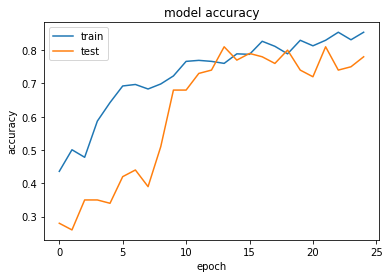

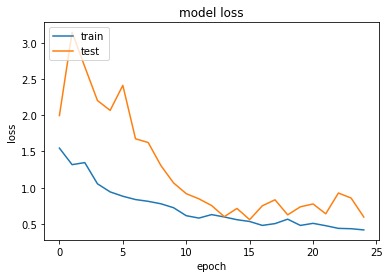

In [ ]:
plot_loss_accuracy(history)

#### Conv 3D Model with 30 frames per video and a 5 by 5 filter size 
16, 32, 64, 128 filters conv 3D layers + 256 dense layer + 128 dense layer + image size 120 by 120

In [14]:
def conv3D_5by5(conv_filters=(16, 32, 64, 128), dense_nodes=(256,128), dropout=0.25, num_images=20, height=120, width=120):

    model = Sequential()

    model.add(Conv3D(conv_filters[0], (5, 5, 5), padding='same', input_shape=(num_images, height, width, 3)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(conv_filters[1], (3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Conv3D(conv_filters[2], (3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Conv3D(conv_filters[3], (3, 3, 3), padding='same'))    
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Flatten())
    model.add(Dense(dense_nodes[0]))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(dense_nodes[1]))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    opt = tf.keras.optimizers.Adam() #write your optimizer
    model.compile(opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])    
    
    return model

In [15]:
num_epochs = 15 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 30
print ('# num_frames per video =', num_frames)
height = 120
width = 120

model = conv3D_5by5(num_images=num_frames)

print (model.summary())

# epochs = 15
# batch size = 10
# num_frames per video = 30
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 30, 120, 120, 16)  6016      
                                                                 
 activation_7 (Activation)   (None, 30, 120, 120, 16)  0         
                                                                 
 batch_normalization_6 (Batc  (None, 30, 120, 120, 16)  64       
 hNormalization)                                                 
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 15, 60, 60, 16)   0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 15, 60, 60, 32)    13856     
                                                            

The steps_per_epoch and validation_steps are used by fit_generator to decide the number of next() calls it need to make. Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [16]:
callbacks_list = model_callbacks("model_conv3D_9")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

Using model.fit to fit the train generator and train the model on the data.

In [17]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/15
67/67 [==============================] - ETA: 0s - loss: 1.5910 - categorical_accuracy: 0.4389
Epoch 1: val_loss improved from inf to 2.52914, saving model to model_conv3D_9_2022-09-1402_44_34.816729/model-00001-1.59101-0.43891-2.52914-0.30000.h5
67/67 [==============================] - 340s 5s/step - loss: 1.5910 - categorical_accuracy: 0.4389 - val_loss: 2.5291 - val_categorical_accuracy: 0.3000 - lr: 0.0010
Epoch 2/15
67/67 [==============================] - ETA: 0s - loss: 1.2468 - categorical_accuracy: 0.5249
Epoch 2: val_loss improved from 2.52914 to 2.40334, saving model to model_conv3D_9_2022-09-1402_44_34.816729/model-00002-1.24680-0.52489-2.40334-0.32000.h5
67/67 [==============================] - 338s 5s/step - loss: 1.2468 - categorical_accuracy: 0.5249 - val_loss: 2.4033 - val_categorical_accuracy: 0.3200 - lr: 0.0010
Epoch 3/15
67/67 [==============================] - ETA: 0s - loss: 1.1393 - categorical_accuracy: 0.5596
Epoch 3: val_loss did not improve from 2

Visualizing the Results

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


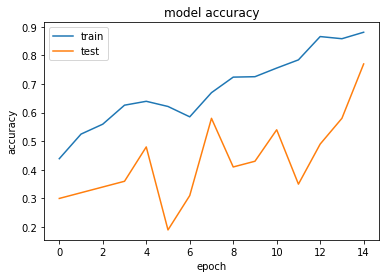

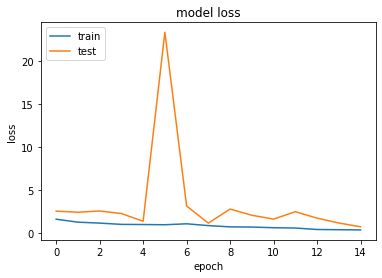

In [18]:
plot_loss_accuracy(history)

### 2. Model Building Using Conv2D + Recurrent Neural Network (RNN)/ Model Building Using Transfer Learning + Recurrent Neural Network (RNN)

#### TRANSFER LEARNING - MobileNet Conv2d + GRU

In [ ]:
from keras.applications import mobilenet

def mobilenet_RNN(fine_tune=False, gru=False, lstm_gru_cells=128, dense_nodes=128, dropout=0.25, num_images=20, height=120, width=120):

    mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)
    print("Number of layers in the pretrained mobilenet model: ", len(mobilenet_transfer.layers))

    if (fine_tune):
        # Fine-tune from this layer onwards
        fine_tune_at = 50
        # Freeze all the layers before the `fine_tune_at` layer
        for layer in mobilenet_transfer.layers[:fine_tune_at]:
            layer.trainable = False

    model = Sequential()
    model.add(TimeDistributed(mobilenet_transfer,input_shape=(num_images, height, width, 3)))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Flatten()))
    if (gru):
        model.add(GRU(lstm_gru_cells))
    else:
        model.add(LSTM(lstm_gru_cells))
    model.add(Dropout(dropout))
    model.add(Dense(dense_nodes, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(num_classes, activation='softmax'))

    opt = tf.keras.optimizers.Adam() #write your optimizer
    model.compile(opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])    
    return model

#### Mobilenet (re train all weights) + GRU (128 cells) + 128 dense nodes

In [ ]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num frames per video =', num_frames)
height = 120
width = 120

model = mobilenet_RNN(num_images=num_frames, gru=True)
print (model.summary())

# epochs = 20
# batch size = 10
# num frames per video = 20
Number of layers in the pretrained mobilenet model:  86
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_12 (TimeDi  (None, 20, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_13 (TimeDi  (None, 20, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_14 (TimeDi  (None, 20, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_15 (TimeDi  (None, 20, 1024)         0         
 stributed)                                                      
    

The steps_per_epoch and validation_steps are used by fit_generator to decide the number of next() calls it need to make. Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [ ]:
callbacks_list = model_callbacks("model_retrain_mobilenet_gru")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

Using model.fit to fit the train generator and train the model on the data.

In [ ]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20
67/67 [==============================] - ETA: 0s - loss: 1.1579 - categorical_accuracy: 0.5309  
Epoch 1: val_loss improved from inf to 0.65876, saving model to model_retrain_mobilenet_gru_2022-09-1115_16_14.501078/model-00001-1.15789-0.53092-0.65876-0.74000.h5
67/67 [==============================] - 5057s 76s/step - loss: 1.1579 - categorical_accuracy: 0.5309 - val_loss: 0.6588 - val_categorical_accuracy: 0.7400 - lr: 0.0010
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 0.6300 - categorical_accuracy: 0.7511
Epoch 2: val_loss improved from 0.65876 to 0.55076, saving model to model_retrain_mobilenet_gru_2022-09-1115_16_14.501078/model-00002-0.63001-0.75113-0.55076-0.75000.h5
67/67 [==============================] - 177s 3s/step - loss: 0.6300 - categorical_accuracy: 0.7511 - val_loss: 0.5508 - val_categorical_accuracy: 0.7500 - lr: 0.0010
Epoch 3/20
67/67 [==============================] - ETA: 0s - loss: 0.3808 - categorical_accuracy: 0.8703
Epoch 3: v

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


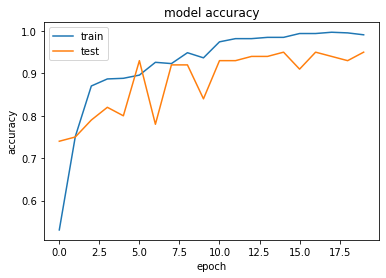

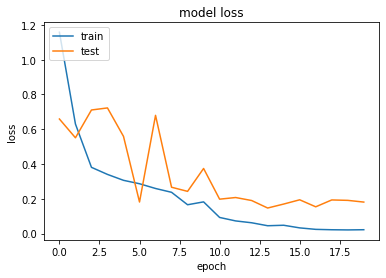

In [ ]:
plot_loss_accuracy(history)

#### Mobilenet (re train all weights) + GRU (128 cells) + 128 dense nodes + Random data transformations on training data set

In [ ]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 30
print ('# num frames per video =', num_frames)
height = 120
width = 120

model = mobilenet_RNN(gru=True, num_images=num_frames)
print(model.summary())

# epochs = 20
# batch size = 10
# num frames per video = 30
Number of layers in the pretrained mobilenet model:  86
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_16 (TimeDi  (None, 30, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_17 (TimeDi  (None, 30, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_18 (TimeDi  (None, 30, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_19 (TimeDi  (None, 30, 1024)         0         
 stributed)                                                      
    

In [ ]:
callbacks_list = model_callbacks("model_retrain_mobilenet_gru")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, augment=True, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

Using model.fit to fit the train generator and train the model on the data.

In [ ]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20
67/67 [==============================] - ETA: 0s - loss: 1.1561 - categorical_accuracy: 0.5234 
Epoch 1: val_loss improved from inf to 0.88751, saving model to model_retrain_mobilenet_gru_2022-09-1115_16_14.501078/model-00001-1.15615-0.52338-0.88751-0.59000.h5
67/67 [==============================] - 2518s 38s/step - loss: 1.1561 - categorical_accuracy: 0.5234 - val_loss: 0.8875 - val_categorical_accuracy: 0.5900 - lr: 0.0010
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 0.5788 - categorical_accuracy: 0.7707
Epoch 2: val_loss improved from 0.88751 to 0.65146, saving model to model_retrain_mobilenet_gru_2022-09-1115_16_14.501078/model-00002-0.57882-0.77074-0.65146-0.78000.h5
67/67 [==============================] - 312s 5s/step - loss: 0.5788 - categorical_accuracy: 0.7707 - val_loss: 0.6515 - val_categorical_accuracy: 0.7800 - lr: 0.0010
Epoch 3/20
67/67 [==============================] - ETA: 0s - loss: 0.4021 - categorical_accuracy: 0.8356
Epoch 3: va

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


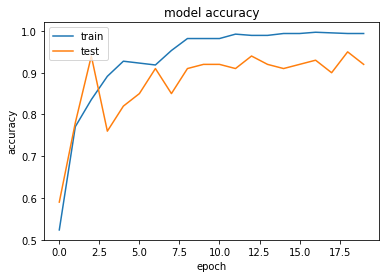

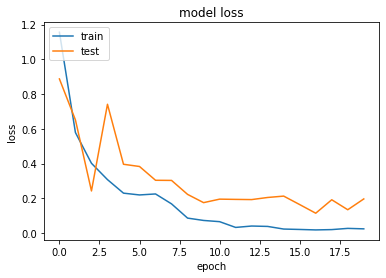

In [ ]:
plot_loss_accuracy(history)

#### Mobilenet (fine tune) + GRU (128 cells) + 128 dense nodes

In [ ]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num frames per video =', num_frames)
height = 120
width = 120

model = mobilenet_RNN(fine_tune=True, gru=True, num_images=num_frames)
print(model.summary())

# epochs = 20
# batch size = 10
# num frames per video = 20
Number of layers in the pretrained mobilenet model:  86
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_20 (TimeDi  (None, 20, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_21 (TimeDi  (None, 20, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_22 (TimeDi  (None, 20, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_23 (TimeDi  (None, 20, 1024)         0         
 stributed)                                                      
    

In [ ]:
callbacks_list = model_callbacks("model_finetune_mobilenet_gru")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

Using model.fit to fit the train generator and train the model on the data.

In [ ]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20
67/67 [==============================] - ETA: 0s - loss: 1.1878 - categorical_accuracy: 0.4992
Epoch 1: val_loss improved from inf to 0.67461, saving model to model_finetune_mobilenet_gru_2022-09-1115_16_14.501078/model-00001-1.18783-0.49925-0.67461-0.74000.h5
67/67 [==============================] - 177s 3s/step - loss: 1.1878 - categorical_accuracy: 0.4992 - val_loss: 0.6746 - val_categorical_accuracy: 0.7400 - lr: 0.0010
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 0.5985 - categorical_accuracy: 0.7662
Epoch 2: val_loss improved from 0.67461 to 0.43811, saving model to model_finetune_mobilenet_gru_2022-09-1115_16_14.501078/model-00002-0.59848-0.76621-0.43811-0.86000.h5
67/67 [==============================] - 172s 3s/step - loss: 0.5985 - categorical_accuracy: 0.7662 - val_loss: 0.4381 - val_categorical_accuracy: 0.8600 - lr: 0.0010
Epoch 3/20
67/67 [==============================] - ETA: 0s - loss: 0.3580 - categorical_accuracy: 0.8899
Epoch 3: val

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


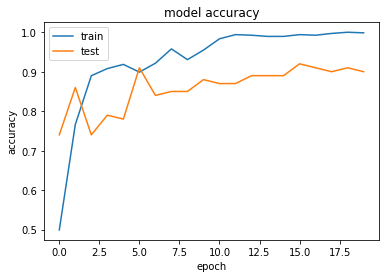

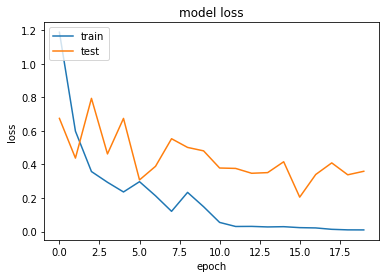

In [ ]:
plot_loss_accuracy(history)

#### Mobilenet (re train all wieghts) + LSTM (128 cells) + 128 dense nodes

In [ ]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num frames per video =', num_frames)
height = 120
width = 120

model = mobilenet_RNN(fine_tune=False, gru=False, num_images=num_frames)
print(model.summary())

# epochs = 20
# batch size = 10
# num frames per video = 20
Number of layers in the pretrained mobilenet model:  86
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_24 (TimeDi  (None, 20, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_25 (TimeDi  (None, 20, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_26 (TimeDi  (None, 20, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_27 (TimeDi  (None, 20, 1024)         0         
 stributed)                                                      
    

In [ ]:
callbacks_list = model_callbacks("model_retrain_mobilenet_lstm")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

Using model.fit to fit the train generator and train the model on the data.

In [ ]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20
67/67 [==============================] - ETA: 0s - loss: 1.2732 - categorical_accuracy: 0.4585
Epoch 1: val_loss improved from inf to 1.36099, saving model to model_retrain_mobilenet_lstm_2022-09-1115_16_14.501078/model-00001-1.27319-0.45852-1.36099-0.36000.h5
67/67 [==============================] - 185s 3s/step - loss: 1.2732 - categorical_accuracy: 0.4585 - val_loss: 1.3610 - val_categorical_accuracy: 0.3600 - lr: 0.0010
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 0.7930 - categorical_accuracy: 0.6621
Epoch 2: val_loss improved from 1.36099 to 0.53476, saving model to model_retrain_mobilenet_lstm_2022-09-1115_16_14.501078/model-00002-0.79297-0.66214-0.53476-0.80000.h5
67/67 [==============================] - 180s 3s/step - loss: 0.7930 - categorical_accuracy: 0.6621 - val_loss: 0.5348 - val_categorical_accuracy: 0.8000 - lr: 0.0010
Epoch 3/20
67/67 [==============================] - ETA: 0s - loss: 0.6436 - categorical_accuracy: 0.7421
Epoch 3: val

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


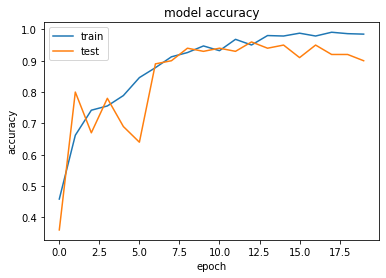

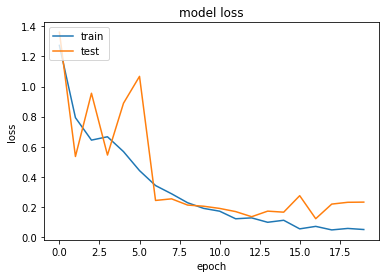

In [ ]:
plot_loss_accuracy(history)

#### Mobilenet (re train all weights) + 64 dense nodes

In [ ]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num frames per video =', num_frames)
height = 120
width = 120

model = mobilenet_RNN(fine_tune=False, gru=True, num_images=num_frames, lstm_gru_cells=128, dense_nodes=64)
print(model.summary())

# epochs = 20
# batch size = 10
# num frames per video = 20
Number of layers in the pretrained mobilenet model:  86
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_28 (TimeDi  (None, 20, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_29 (TimeDi  (None, 20, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_30 (TimeDi  (None, 20, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_31 (TimeDi  (None, 20, 1024)         0         
 stributed)                                                      
    

In [ ]:
callbacks_list = model_callbacks("model_retrain_mobilenet_gru_64")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

Using model.fit to fit the train generator and train the model on the data.

In [ ]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator,
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20
67/67 [==============================] - ETA: 0s - loss: 1.2011 - categorical_accuracy: 0.5204
Epoch 1: val_loss improved from inf to 0.58839, saving model to model_retrain_mobilenet_gru_64_2022-09-1115_16_14.501078/model-00001-1.20110-0.52036-0.58839-0.80000.h5
67/67 [==============================] - 182s 3s/step - loss: 1.2011 - categorical_accuracy: 0.5204 - val_loss: 0.5884 - val_categorical_accuracy: 0.8000 - lr: 0.0010
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 0.5837 - categorical_accuracy: 0.7873
Epoch 2: val_loss improved from 0.58839 to 0.44275, saving model to model_retrain_mobilenet_gru_64_2022-09-1115_16_14.501078/model-00002-0.58366-0.78733-0.44275-0.81000.h5
67/67 [==============================] - 178s 3s/step - loss: 0.5837 - categorical_accuracy: 0.7873 - val_loss: 0.4428 - val_categorical_accuracy: 0.8100 - lr: 0.0010
Epoch 3/20
67/67 [==============================] - ETA: 0s - loss: 0.4715 - categorical_accuracy: 0.8054
Epoch 3:

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


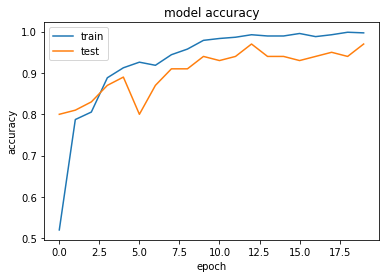

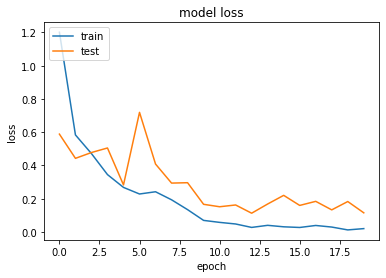

In [ ]:
plot_loss_accuracy(history)

#### Mobilenet (re train all weights) + 64 dense nodes + on training data set + Random data transformations

In [ ]:
num_epochs = 25 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num frames per video =', num_frames)
height = 120
width = 120

model = mobilenet_RNN(fine_tune=False, gru=False, num_images=num_frames, lstm_gru_cells=128, dense_nodes=64)
print(model.summary())

# epochs = 25
# batch size = 10
# num frames per video = 20
Number of layers in the pretrained mobilenet model:  86
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_32 (TimeDi  (None, 20, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_33 (TimeDi  (None, 20, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_34 (TimeDi  (None, 20, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_35 (TimeDi  (None, 20, 1024)         0         
 stributed)                                                      
    

In [ ]:
callbacks_list = model_callbacks("model_retrain_mobilenet_gru_64")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, augment=True, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

Using model.fit to fit the train generator and train the model on the data.

In [ ]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator,
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/25
67/67 [==============================] - ETA: 0s - loss: 1.1299 - categorical_accuracy: 0.5264
Epoch 1: val_loss improved from inf to 0.78724, saving model to model_retrain_mobilenet_gru_64_2022-09-1115_16_14.501078/model-00001-1.12992-0.52640-0.78724-0.65000.h5
67/67 [==============================] - 211s 3s/step - loss: 1.1299 - categorical_accuracy: 0.5264 - val_loss: 0.7872 - val_categorical_accuracy: 0.6500 - lr: 0.0010
Epoch 2/25
67/67 [==============================] - ETA: 0s - loss: 0.6258 - categorical_accuracy: 0.7572
Epoch 2: val_loss improved from 0.78724 to 0.51196, saving model to model_retrain_mobilenet_gru_64_2022-09-1115_16_14.501078/model-00002-0.62575-0.75716-0.51196-0.84000.h5
67/67 [==============================] - 206s 3s/step - loss: 0.6258 - categorical_accuracy: 0.7572 - val_loss: 0.5120 - val_categorical_accuracy: 0.8400 - lr: 0.0010
Epoch 3/25
67/67 [==============================] - ETA: 0s - loss: 0.5476 - categorical_accuracy: 0.8024
Epoch 3:

Visualizing the results

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


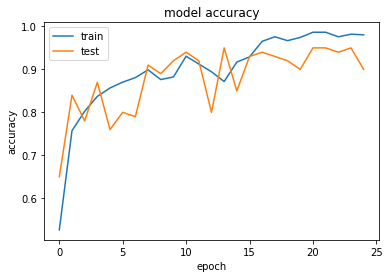

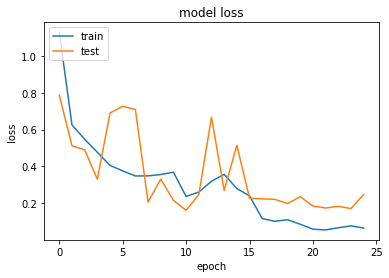

In [ ]:
plot_loss_accuracy(history)

## Conclusion
Hence I was sucesssfully able to design a gesture recognition model using two different approaches viz. Conv3D approach and Conv2D+RNN approach. For Conv2D I used transfer learning with mobilenet model.Both the approaches performed very well with training accuracy of 
`95.32 %` and `99.85 %` respectively. It also performed well on the validation data with accuracy of `88.00 %` and `97.00 %` 

## **Note**
The zip file which I have submitted consists of the following things: -
1. Write-Up
2. Code file which consists of generator function and model training.
3. The final (best) model weights - CNN(Transfer Learning) + RNN.
4. Due to upload limit constraint I have uploaded the final (best) model weights of Conv3D model on github. Link for this weight file - https://github.com/Ashu1905/Gesture_Recognition_Neural_Networks_Project